## Step 1: Import SVHN dataset

In [1]:
import h5py
import torchvision
import torchvision.transforms as transforms
import cv2
import os
import numpy as np
import glob
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
# local_path = "../.." <- please change dir here
local_path = "../.."

## Step 2: Data Preprocessing

### 2a. Crop Images and Convert to grayscale

In [3]:
# following class are used for image crop and get cropped image path 
class CropImage(object):
    def __init__ (self, local_path, mode, grayscale=True):
        # load digitStruct.mat
        self.local_path = local_path
        self.mode = mode
        self.grayscale = grayscale
        if mode == "train":
            self.f = h5py.File(local_path + "/train/digitStruct.mat", 'r')
        elif mode == "test":
            self.f = h5py.File(local_path + "/test/digitStruct.mat", 'r')
        # get dataset for each group
        self.digitStructName = self.f['digitStruct']['name']
        self.digitStructBbox = self.f['digitStruct']['bbox']
        self.file_path_dict = {}
        
    # get bbox for each instance. bbox is a library describing the bounder box position
    def get_bbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        def bbox_helper(attr_type):
            attr = self.f[bb][attr_type]
            if len(attr) > 1:
                pos = [int(self.f[attr[j].item()][0][0]) for j in range(len(attr))]
            else:
                pos = [attr[0][0]]

            return pos
        bbox['label'] = bbox_helper('label')
        bbox['height'] = bbox_helper('height')
        bbox['left'] = bbox_helper('left')
        bbox['top'] = bbox_helper('top')
        bbox['width'] = bbox_helper('width')
        return bbox

    # get file name for each instance. File names are indexes starting from 1
    def get_name(self, n):
        name = ''.join([chr(v[0]) for v in self.f[(self.digitStructName[n][0])]])
        return name

    def save_path_to_dict(self, original_file_name, save_file_path, img):
        # save path to dict
        if original_file_name not in self.file_path_dict:
            self.file_path_dict[original_file_name] = [save_file_path]
        elif save_file_path not in self.file_path_dict[original_file_name]:
            self.file_path_dict[original_file_name].append(save_file_path)
        # save cropped image
        torchvision.utils.save_image(img, save_file_path)

    # crop image for each instance, also save cropped image name to the dict
    def crop_image(self, n):
        n_drop = 0
        # for each label, crop the image
        digit_dict = self.get_bbox(n)
        
        for label_index in range(len(digit_dict['label'])):
            label = int(digit_dict['label'][label_index])
            # label 0 is represented using 10
            if label == 10:
                label = 0

            # get crop position
            left = int(digit_dict['left'][label_index])
            upper = int(digit_dict['top'][label_index])
            right = int(left + digit_dict['width'][label_index])
            lower = int(upper + digit_dict['height'][label_index])

            # invalid data
            if left < 0 or upper < 0:
                n_drop += 1
                continue

            # crop image
            img_path_crop_test = self.local_path + '/' + self.mode + '/' + self.get_name(n)
            image = cv2.imread(img_path_crop_test)
            img = image[upper:lower, left:right, :]

            if self.grayscale == True:
                # transpose image into size 32 * 32 grayscale tensor format
                transformed_img = transforms.Compose(
                        [transforms.ToPILImage(),
                        transforms.Grayscale(num_output_channels=1),
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])(img)
                # ref: http://man.hubwiz.com/docset/torchvision.docset/Contents/Resources/Documents/transforms.html
            else:
                 # If num_output_channels == 1 : returned image is single channel If num_output_channels == 3 : returned image is 3 channel with r == g == b
                transformed_img = transforms.Compose(
                        [transforms.ToPILImage(),
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])(img)

            grayscale_text = 'single' if self.grayscale == True else 'rgb'
            process_folder = self.local_path + '/process/' + self.mode + '/' + grayscale_text +'/'
            # check whether the process folder exists or not
            if not os.path.exists(process_folder):
                # create a new directory because it does not exist
                os.makedirs(process_folder)
                print("Created the process folder to store preprocessed images")

            # store image as original file name + _ + label + _ + label index, saved in process folder
            original_file_name = self.get_name(n).split('.')[0]

            file_head = '_'.join([process_folder + original_file_name, str(label_index), str(label)])
            file_tail = '.png'
            inverted_file_tail = '_iv.png'

            # invert grayscale image to get a new image, by doing so we could expande our training data set
            if self.mode == "train":
                inverted_transformed_img = transforms.functional.invert(transformed_img)
                self.save_path_to_dict(original_file_name, file_head+inverted_file_tail, inverted_transformed_img)
        
            self.save_path_to_dict(original_file_name, file_head+file_tail, transformed_img)
    
    # get a list of cropped image file path
    def get_cropped_image_path(self, n):
        curr_path = self.local_path + '/' + self.mode + '/'
        # check the file name is out of range, max is 33401 for train, 13065 for test
        if n + 1 not in self.file_path_dict:
            if n + 2 >= len(os.listdir(curr_path)): # changed from 3 to 2
                print("Please check the file name!")
            else:
                # havent been processed yet
                self.crop_image(n)
        # return a list of file path name of the cropped file 
        return self.file_path_dict[str(n+1)]

### 2b. Create train and test datasets

In [5]:
def get_cropped_images(cropped_img_dir_list):
    '''
    Return a list of images of a single number
    e.g. Original image = 210, return image of 2, 1, 0
    '''
    output = []
    for cropped_img_dir in cropped_img_dir_list:
        output.append(cv2.imread(cropped_img_dir))
    return output

def get_labels(data, idx, multiplier=1):
    '''
    Return a list of labels. Convert label 10 -> 0
    '''
    output = []
    for l in data.get_bbox(idx)['label']:
        output += [0] * multiplier if l == 10 else [int(l)]* multiplier
    return output

def create_input(local_path, mode, grayscale): # <- possible a better function name?
    '''
    Return lists of train/test
    '''
    X, y, image_number = [], [], []
    data = CropImage(local_path, mode, grayscale)
    dataset_path = local_path + "/" + mode
    total_image_num = len(glob.glob1(dataset_path, "*.png"))

    for idx in range(total_image_num):
        try:
            cropped_img_dir_list = data.get_cropped_image_path(idx)
            # Two images per number in the train, and only one in the test
            multiplier = 2 if mode == "train" else 1

            # Check if number of Cropped img == number of labels
            if len(cropped_img_dir_list) != len(
                    data.get_bbox(idx)['label'] * multiplier):
                print(
                    "Skipped {}.png, Number of cropped image is inconsistent with labels"
                    .format(idx + 1))
                continue

            X += get_cropped_images(cropped_img_dir_list)
            y += get_labels(data, idx, multiplier)
            image_number += [idx] * len(cropped_img_dir_list)

        except:
            # Failed to crop image
            print("Skipped {}.png, No cropped image output".format(idx + 1))
            continue

    return np.array(X), np.array(y), np.array(image_number)

In [6]:
# Create grayscaled train and test datasets
X_train, y_train, image_train = create_input(local_path, mode="train", grayscale=True)
X_test, y_test, img_number = create_input(local_path, mode="test", grayscale=True)

Created the process folder to store preprocessed images
Skipped 252.png, Number of cropped image is inconsistent with labels
Skipped 724.png, Number of cropped image is inconsistent with labels
Skipped 3100.png, Number of cropped image is inconsistent with labels
Skipped 5312.png, Number of cropped image is inconsistent with labels
Skipped 6877.png, No cropped image output
Skipped 9357.png, Number of cropped image is inconsistent with labels
Skipped 11861.png, No cropped image output
Skipped 13145.png, No cropped image output
Skipped 15125.png, Number of cropped image is inconsistent with labels
Skipped 18277.png, Number of cropped image is inconsistent with labels
Skipped 18393.png, Number of cropped image is inconsistent with labels
Skipped 19383.png, Number of cropped image is inconsistent with labels
Skipped 20540.png, Number of cropped image is inconsistent with labels
Skipped 20901.png, Number of cropped image is inconsistent with labels
Skipped 20915.png, Number of cropped image

In [7]:
# Create *colored* train and test datasets ETA 33min
X_train_colored, y_train_colored, colored_train_num = create_input(local_path, mode="train", grayscale=False)
X_test_colored, y_test_colored, colored_test_num = create_input(local_path, mode="test", grayscale=False)

Created the process folder to store preprocessed images
Skipped 252.png, Number of cropped image is inconsistent with labels
Skipped 724.png, Number of cropped image is inconsistent with labels
Skipped 3100.png, Number of cropped image is inconsistent with labels
Skipped 5312.png, Number of cropped image is inconsistent with labels
Skipped 6877.png, No cropped image output
Skipped 9357.png, Number of cropped image is inconsistent with labels
Skipped 11861.png, No cropped image output
Skipped 13145.png, No cropped image output
Skipped 15125.png, Number of cropped image is inconsistent with labels
Skipped 18277.png, Number of cropped image is inconsistent with labels
Skipped 18393.png, Number of cropped image is inconsistent with labels
Skipped 19383.png, Number of cropped image is inconsistent with labels
Skipped 20540.png, Number of cropped image is inconsistent with labels
Skipped 20901.png, Number of cropped image is inconsistent with labels
Skipped 20915.png, Number of cropped image

In [8]:
# save results to file

# import json
# with open("X_train", "w") as fp:
#     json.dump(X_train.tolist(), fp)

# with open("y_train", "w") as fp:
#     json.dump(y_train.tolist(), fp)

# with open("X_test", "w") as fp:
#     json.dump(X_test.tolist(), fp)

# with open("y_test", "w") as fp:
#     json.dump(y_test.tolist(), fp)

# with open("X_train_colored", "w") as fp:
#     json.dump(X_train_colored.tolist(), fp)

# with open("y_train_colored", "w") as fp:
#     json.dump(y_train_colored.tolist(), fp)

# with open("X_test_colored", "w") as fp:
#     json.dump(X_test_colored.tolist(), fp)

# with open("y_test_colored", "w") as fp:
#     json.dump(y_test_colored.tolist(), fp)


## Step 3: Create CNN model

In [10]:
# Create CNN base model
cnn_model = models.Sequential()
'''
[1] convolution layer + [2] ReLU R(z) = max(0, z)
filters 32 -> detect 32 different/features in the image, filter size 3 x 3
'''
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))

'''
[3] pooling layer, looking for the max value in a 2 x 2 filter
down-sampling operations that reduces the dimensionality of the feature map
detect edges, corners
'''
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

'''
flattening - converting all the resultant 2d arrays from pooled feature map to a single long continuous linear vector
'''
cnn_model.add(layers.Flatten()) 
cnn_model.add(layers.Dense(64, activation='relu'))
'''
[4] fully connected layer to identify the numbers 
'''
cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 3a. Choose the optimal number of epochs

In [27]:
# Create CNN base model
model_epoch_diff = models.Sequential()
model_epoch_diff.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_epoch_diff.add(layers.MaxPooling2D((2, 2)))
model_epoch_diff.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_diff.add(layers.MaxPooling2D((2, 2)))
model_epoch_diff.add(layers.Flatten()) 
model_epoch_diff.add(layers.Dense(64, activation='relu'))
model_epoch_diff.add(layers.Dense(10, activation='softmax'))
model_epoch_diff.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def find_optimal_epoch(model, X_train, y_train, X_test, y_test, epoch_num):
    test_loss_list, test_accuracy_list, train_loss_list, train_accuracy_list = [],[],[],[]
    
    for _ in range(1, epoch_num + 1):
        h = model.fit(X_train, y_train, epochs=1)
        train_loss = h.history['loss']
        train_loss_list.append(train_loss)
        train_accuracy = h.history['accuracy']
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = model.evaluate(X_test,y_test)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
    return test_loss_list, test_accuracy_list, train_loss_list, train_accuracy_list

test_loss_list, test_accuracy_list, train_loss_list, train_accuracy_list = find_optimal_epoch(model_epoch_diff, X_train, y_train, X_test, y_test, 15)

813/813 [==============================] - 3s 4ms/step - loss: 0.5450 - accuracy: 0.8713: 0s - loss: 0.5462 - accura


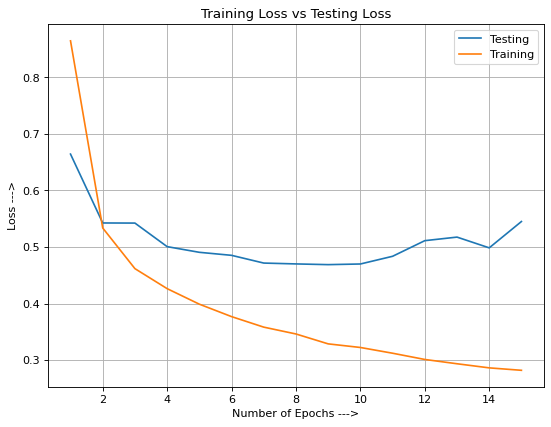

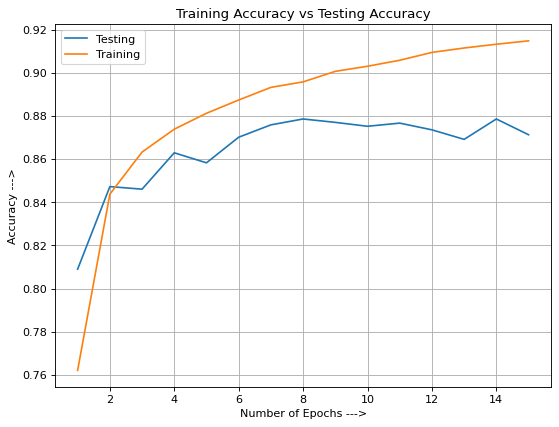

In [35]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
x = list(range(1, 16))
plt.plot(x, test_loss_list, label="Testing") 
plt.plot(x, train_loss_list, label="Training") 
plt.legend()
plt.grid()
plt.title("Training Loss vs Testing Loss")
plt.xlabel("Number of Epochs --->")
plt.ylabel("Loss --->")
plt.show()


figure(figsize=(8, 6), dpi=80)
plt.plot(x, test_accuracy_list, label="Testing") 
plt.plot(x, train_accuracy_list, label="Training") 
plt.legend()
plt.grid()
plt.title("Training Accuracy vs Testing Accuracy")
plt.xlabel("Number of Epochs --->")
plt.ylabel("Accuracy --->")
plt.show()

**Finding**
* As the number of epochs increases beyond 8, the loss for testing starts to increase and the accuracy stops increasing, which are the signs of the overfitting of the model on training data.
* We choose 8 numbers of epochs, considering the loss, accuracy, and time of training. 

* Ref: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/

### 3b. Deciding optimal kernel size

##### Kernel size 3x3

In [13]:
# Try a kernel of 3x3 size in the convolutional layer to see if accuracy improved
model_3x3_kernel = models.Sequential()
model_3x3_kernel.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_3x3_kernel.add(layers.MaxPooling2D((2, 2)))

model_3x3_kernel.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3x3_kernel.add(layers.MaxPooling2D((2, 2)))

model_3x3_kernel.add(layers.Flatten()) 
model_3x3_kernel.add(layers.Dense(64, activation='relu'))
model_3x3_kernel.add(layers.Dense(10, activation='softmax'))
model_3x3_kernel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3x3_kernel.fit(X_train, y_train, epochs=8)
model_3x3_kernel.evaluate(X_test,y_test) 


Epoch 1/8
4575/4575 [==============================] - 62s 13ms/step - loss: 0.8450 - accuracy: 0.7645
Epoch 2/8
4575/4575 [==============================] - 63s 14ms/step - loss: 0.5804 - accuracy: 0.8294
Epoch 3/8
4575/4575 [==============================] - 63s 14ms/step - loss: 0.5314 - accuracy: 0.8434
Epoch 4/8
4575/4575 [==============================] - 62s 14ms/step - loss: 0.4972 - accuracy: 0.8531
Epoch 5/8
4575/4575 [==============================] - 70s 15ms/step - loss: 0.4732 - accuracy: 0.8600
Epoch 6/8
4575/4575 [==============================] - 65s 14ms/step - loss: 0.4489 - accuracy: 0.8678
Epoch 7/8
4575/4575 [==============================] - 68s 15ms/step - loss: 0.4308 - accuracy: 0.8724
Epoch 8/8
813/813 [==============================] - 3s 4ms/step - loss: 0.5104 - accuracy: 0.8565


[0.5104240775108337, 0.8565113544464111]

#### Kernel size 5x5

In [46]:
# Try a kernel of 5x5 size in the convolutional layer to see if accuracy improved
model_5x5_kernel = models.Sequential()

model_5x5_kernel.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
model_5x5_kernel.add(layers.MaxPooling2D((2, 2)))

model_5x5_kernel.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_5x5_kernel.add(layers.MaxPooling2D((2, 2)))

model_5x5_kernel.add(layers.Flatten()) 
model_5x5_kernel.add(layers.Dense(64, activation='relu'))
model_5x5_kernel.add(layers.Dense(10, activation='softmax'))
model_5x5_kernel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model_5x5_kernel.fit(X_train, y_train, epochs=8)


Epoch 1/8
4575/4575 [==============================] - 78s 17ms/step - loss: 0.7753 - accuracy: 0.7849
Epoch 2/8
4575/4575 [==============================] - 78s 17ms/step - loss: 0.5331 - accuracy: 0.8465
Epoch 3/8
4575/4575 [==============================] - 75s 16ms/step - loss: 0.4751 - accuracy: 0.8633
Epoch 4/8
4575/4575 [==============================] - 81s 18ms/step - loss: 0.4490 - accuracy: 0.8716
Epoch 5/8
4575/4575 [==============================] - 80s 17ms/step - loss: 0.4303 - accuracy: 0.8765
Epoch 6/8
4575/4575 [==============================] - 74s 16ms/step - loss: 0.4208 - accuracy: 0.8794
Epoch 7/8
4575/4575 [==============================] - 73s 16ms/step - loss: 0.4090 - accuracy: 0.8827
Epoch 8/8
4575/4575 [==============================] - 73s 16ms/step - loss: 0.4114 - accuracy: 0.8824


In [ ]:
# running spped data captured from the output above
time_3x3 = 14 # ms/step
time_5x5 = 17 

loss_3x3, accuracy_3x3 = model_3x3_kernel.evaluate(X_test, y_test)
loss_5x5, accuracy_5x5 = model_5x5_kernel.evaluate(X_test, y_test)

Text(0.5, 1.0, '3x3 vs. 5x5 Kernel Size Performance Comparison ')

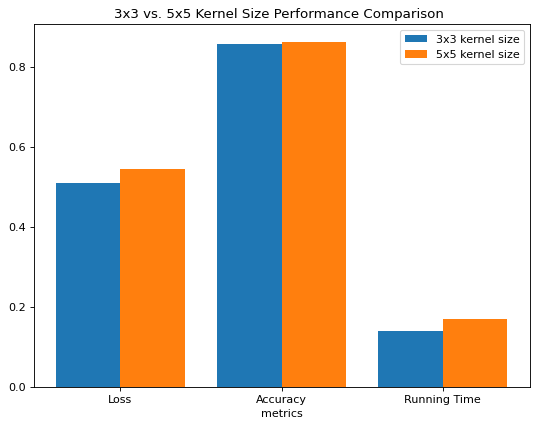

In [60]:
# visualize performance metrics
figure(figsize=(8, 6), dpi=80)
w=0.4
x = ['Loss', 'Accuracy', 'Running Time']
kernel_3x3 = [loss_3x3, accuracy_3x3, time_3x3 / 100] # divide by 100 for better visualisation
kernel_5x5 = [loss_5x5, accuracy_5x5, time_5x5 / 100]
bar1 = np.arange(len(x))
bar2 = [i + w for i in bar1]
plt.bar(bar1, kernel_3x3, w, label = '3x3 kernel size')
plt.bar(bar2, kernel_5x5, w, label = '5x5 kernel size')
plt.xticks(bar1 + w/2, x)
plt.legend()
plt.xlabel("metrics")
plt.title("3x3 vs. 5x5 Kernel Size Performance Comparison ")

* It's a common practice to choose an odd-sized filter because the previous layer pixels will be symmetrical around the output pixel. 
* Compared to 5x5 kernel size, 3x3 has a higher prediction accuracy and costs less time per step. 
* Thus, we will choose the 3x3 kernel size

* Ref: https://medium.com/analytics-vidhya/significance-of-kernel-size-200d769aecb1#:~:text=For%20an%20odd%2Dsized%20filter,to%20suffer%20with%20aliasing%20error.

### 3c. Number of (Conv + Max Pooling) layers

##### 1 set of convolution + max pooling

In [14]:
# 1 set of convolution + pooling layers
model1 = models.Sequential()
model1.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Flatten()) 
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.fit(X_train, y_train, epochs=8)

Epoch 1/8
4575/4575 [==============================] - 44s 10ms/step - loss: 1.4499 - accuracy: 0.6853
Epoch 2/8
4575/4575 [==============================] - 49s 11ms/step - loss: 0.7474 - accuracy: 0.7799
Epoch 3/8
4575/4575 [==============================] - 48s 10ms/step - loss: 0.7672 - accuracy: 0.7668
Epoch 4/8
4575/4575 [==============================] - 46s 10ms/step - loss: 0.6374 - accuracy: 0.8137
Epoch 5/8
4575/4575 [==============================] - 45s 10ms/step - loss: 0.6091 - accuracy: 0.8213
Epoch 6/8
4575/4575 [==============================] - 46s 10ms/step - loss: 0.5877 - accuracy: 0.8265
Epoch 7/8
4575/4575 [==============================] - 47s 10ms/step - loss: 0.5751 - accuracy: 0.8299
Epoch 8/8
4575/4575 [==============================] - 45s 10ms/step - loss: 0.5643 - accuracy: 0.8333


2 sets of convolution + pooling layers

In [186]:
# 2 sets of convolution + pooling layers
model2 = models.Sequential()

model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten()) 
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(X_train, y_train, epochs=8)

Epoch 1/8
4575/4575 [==============================] - 63s 14ms/step - loss: 0.9496 - accuracy: 0.7220
Epoch 2/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.5990 - accuracy: 0.8273
Epoch 3/8
4575/4575 [==============================] - 61s 13ms/step - loss: 0.5486 - accuracy: 0.8416
Epoch 4/8
4575/4575 [==============================] - 62s 13ms/step - loss: 0.5168 - accuracy: 0.8495
Epoch 5/8
4575/4575 [==============================] - 62s 14ms/step - loss: 0.4925 - accuracy: 0.8564
Epoch 6/8
4575/4575 [==============================] - 69s 15ms/step - loss: 0.4747 - accuracy: 0.8612
Epoch 7/8
4575/4575 [==============================] - 67s 15ms/step - loss: 0.4582 - accuracy: 0.8656
Epoch 8/8
4575/4575 [==============================] - 66s 14ms/step - loss: 0.4502 - accuracy: 0.8674


3 sets of convolution + pooling layers

In [85]:
# 3 sets of convolution + pooling layers

model3 = models.Sequential()

model3.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten()) 
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.fit(X_train, y_train, epochs=8)
loss_gray, accuracy_gray = model3.evaluate(X_test, y_test)

Epoch 1/8
4575/4575 [==============================] - 69s 15ms/step - loss: 0.8093 - accuracy: 0.7616
Epoch 2/8
4575/4575 [==============================] - 73s 16ms/step - loss: 0.5260 - accuracy: 0.8453
Epoch 3/8
4575/4575 [==============================] - 68s 15ms/step - loss: 0.4640 - accuracy: 0.8634
Epoch 4/8
4575/4575 [==============================] - 68s 15ms/step - loss: 0.4274 - accuracy: 0.8740
Epoch 5/8
4575/4575 [==============================] - 68s 15ms/step - loss: 0.4063 - accuracy: 0.8792
Epoch 6/8
4575/4575 [==============================] - 71s 16ms/step - loss: 0.3923 - accuracy: 0.8833
Epoch 7/8
4575/4575 [==============================] - 70s 15ms/step - loss: 0.3790 - accuracy: 0.8871
Epoch 8/8
813/813 [==============================] - 4s 5ms/step - loss: 0.4327 - accuracy: 0.8754


813/813 [==============================] - 3s 4ms/step - loss: 0.4247 - accuracy: 0.8753


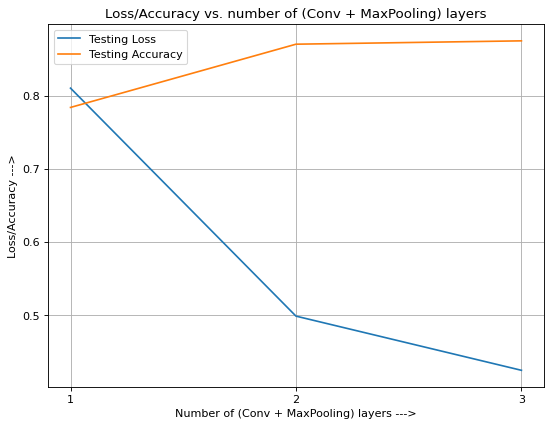

In [43]:
def compare_models(model_list, X_test, y_test):
    lost_list, accuracy_list = [None], [None]
    for m in model_list:
        lost, accuracy = m.evaluate(X_test,y_test) 
        lost_list.append(lost)
        accuracy_list.append(accuracy)

    figure(figsize=(8, 6), dpi=80)
    plt.xticks(range(1,4))
    plt.plot(lost_list, label="Testing Loss") 
    plt.plot(accuracy_list, label="Testing Accuracy") 
    plt.legend()
    plt.grid()
    plt.title("Loss/Accuracy vs. number of (Conv + MaxPooling) layers")
    plt.xlabel("Number of (Conv + MaxPooling) layers --->")
    plt.ylabel("Loss/Accuracy --->")
    plt.show()

model_list = [model1, model2, model3]
compare_models(model_list, X_test, y_test)

* From the graph above, the accuracy is proportional to the number of layers. 
* The time of training models is proportional to the number of layers. 
* From the perspective of time efficiency and accuracy, we will choose 3 sets of convolutional and maxPooling layers in our model. 

### 3d. Colored vs Grayscale Input

In [87]:
# Create CNN model
model_colored = models.Sequential()
model_colored.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model_colored.add(layers.MaxPooling2D((2, 2)))

model_colored.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_colored.add(layers.MaxPooling2D((2, 2)))

model_colored.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_colored.add(layers.MaxPooling2D((2, 2)))

model_colored.add(layers.Flatten()) 
model_colored.add(layers.Dense(64, activation='relu'))
model_colored.add(layers.Dense(10, activation='softmax'))

model_colored.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_colored.fit(X_train_colored, y_train_colored, epochs=8)
loss_colored, accuracy_colored = model_colored.evaluate(X_test_colored,y_test_colored) 

Epoch 1/8
4575/4575 [==============================] - 72s 16ms/step - loss: 1.5157 - accuracy: 0.4822
Epoch 2/8
4575/4575 [==============================] - 71s 15ms/step - loss: 0.5857 - accuracy: 0.8304
Epoch 3/8
4575/4575 [==============================] - 70s 15ms/step - loss: 0.5019 - accuracy: 0.8547
Epoch 4/8
4575/4575 [==============================] - 70s 15ms/step - loss: 0.4563 - accuracy: 0.8663
Epoch 5/8
4575/4575 [==============================] - 71s 16ms/step - loss: 0.4334 - accuracy: 0.8741
Epoch 6/8
4575/4575 [==============================] - 71s 15ms/step - loss: 0.4140 - accuracy: 0.8780
Epoch 7/8
4575/4575 [==============================] - 70s 15ms/step - loss: 0.3989 - accuracy: 0.8823
Epoch 8/8
813/813 [==============================] - 4s 5ms/step - loss: 0.4207 - accuracy: 0.8821


Text(0.5, 1.0, 'Grayscaled vs. Colored Input')

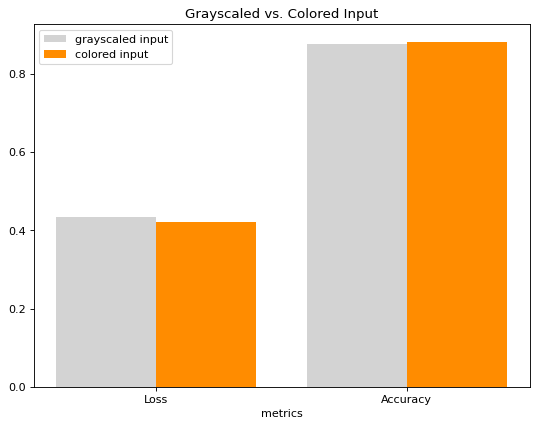

In [88]:
# visualize performance metrics
figure(figsize=(8, 6), dpi=80)
w=0.4
x = ['Loss', 'Accuracy']
grayscaled_metrics = [loss_gray, accuracy_gray] 
colored_metrics = [loss_colored, accuracy_colored]
bar1 = np.arange(len(x))
bar2 = [i + w for i in bar1]
plt.bar(bar1, grayscaled_metrics, w, label = 'grayscaled input', color = 'lightgrey')
plt.bar(bar2, colored_metrics, w, label = 'colored input', color = 'darkorange')
plt.xticks(bar1 + w/2, x)
plt.legend()
plt.xlabel("metrics")
plt.title("Grayscaled vs. Colored Input")

## Step 4: Train & Test

In [20]:
# Optimized model
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [136]:
model.fit(X_train, y_train, epochs=8)

Epoch 1/8
4575/4575 [==============================] - 66s 15ms/step - loss: 0.3419 - accuracy: 0.8998
Epoch 2/8
4575/4575 [==============================] - 67s 15ms/step - loss: 0.3383 - accuracy: 0.9006
Epoch 3/8
4575/4575 [==============================] - 67s 15ms/step - loss: 0.3320 - accuracy: 0.9018
Epoch 4/8
4575/4575 [==============================] - 67s 15ms/step - loss: 0.3285 - accuracy: 0.9035
Epoch 5/8
4575/4575 [==============================] - 66s 15ms/step - loss: 0.3250 - accuracy: 0.9042
Epoch 6/8
4575/4575 [==============================] - 67s 15ms/step - loss: 0.3190 - accuracy: 0.9061
Epoch 7/8
4575/4575 [==============================] - 68s 15ms/step - loss: 0.3190 - accuracy: 0.9057
Epoch 8/8
4575/4575 [==============================] - 67s 15ms/step - loss: 0.3128 - accuracy: 0.9071


[0.40529149770736694, 0.8924892544746399]

In [172]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 256)              

#### a. Accuracy of cropped image with single digit

In [174]:
loss, accuracy = model.evaluate(X_test,y_test, verbose = 0)
print("Loss of single digit:", loss)
print("Accuracy of single digit:", accuracy)

Loss of single digit: 0.40529149770736694
Accuracy of single digit: 0.8924892544746399


In [175]:
# generate predictions and save model
y_pred = np.array([np.argmax(y) for y in model.predict(X_test)])

#### b. Accuracy of predicting using original image

In [178]:
# group data by y_pred, y_test and img_number
grouped_dict_pred = {}
grouped_dict_test = {}

for i in range(len(y_pred)):
    img = img_number[i]
    if img in grouped_dict_test:
        grouped_dict_test[img].append(y_test[i])
    else:
        grouped_dict_test[img] = [y_test[i]]
    
    if img in grouped_dict_pred:
        grouped_dict_pred[img].append(y_pred[i])
    else:
        grouped_dict_pred[img] = [y_pred[i]]

In [182]:
# count successful predicted images and calculate the accuracy
cnt = 0
for i in img_number:
    if grouped_dict_pred[i] == grouped_dict_test[i]:
        cnt += 1

#Accuracy!
acc = cnt / len(img_number)
wrong_cnt = len(img_number) - cnt

print("Accuracy for prediction on the original image: ", acc)

Accuracy for prediction on the original image:  0.8028136531365314


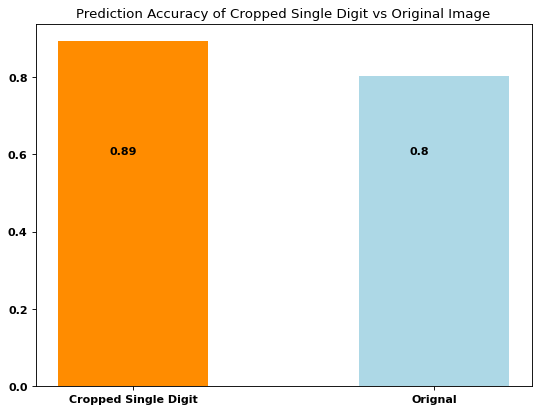

In [176]:
# add a bar plot for grouped & separate prediction
fig = plt.figure(figsize=(8, 6), dpi=80)
x = ['Cropped Single Digit', 'Orignal']
y = [accuracy, acc]
plt.bar(x, y, color =['darkorange', 'lightblue'],
        width = 0.5, align='center')
plt.title("Prediction Accuracy of Cropped Single Digit vs Original Image")
plt.text(-0.08, 0.6, round(y[0], 2))
plt.text(0.92, 0.6, round(y[1], 2))
plt.show()

#### c.Prediction Examples

##### a. Cropped image, single digit

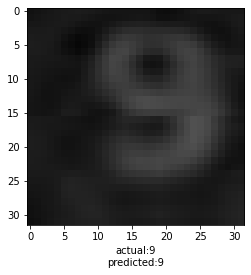

In [146]:
# Plot cropped image with predicted& actual labels
def plot_cropped_image(X, y, y_pred, idx):
    plt.imshow(X[idx])
    label = "actual:" + str(int(y[idx])) + "\npredicted:" + str(y_pred[idx])
    plt.xlabel(label)

image_index = 6
plot_cropped_image(X_test, y_test, y_pred, image_index)

##### b. Original image, one or more digits

In [149]:
import matplotlib.pyplot as plt
import matplotlib.image as img

# Plot original image with predicted& actual labels
def display_image_with_pred(cnn_model, img_index, local_path):
    mode = "test"
    data = CropImage(local_path, mode)
    img_dir = data.get_cropped_image_path(img_index - 1)
    X = get_cropped_images(img_dir)
    y = get_labels(data, img_index - 1)
    
    y_pred = [np.argmax(y) for y in cnn_model.predict(np.array(X))]
    
    path = local_path + "/" + mode+"/" + str(img_index) + ".png"
    plt.imshow(img.imread(path))
    
    conclusion = "Correct Prediction" if y == y_pred else "Incorrect Prediction"
    label = "actual: " + str(y) + "\npredicted: " + str(y_pred) + "\n" + conclusion
    plt.xlabel(label)

    title = "{}.png".format(img_index)
    plt.title(title)

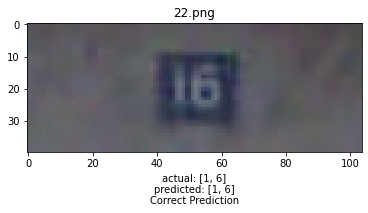

In [151]:
# Example of a Correct Prediction
img_index = 22 
display_image_with_pred(model, img_index, local_path)

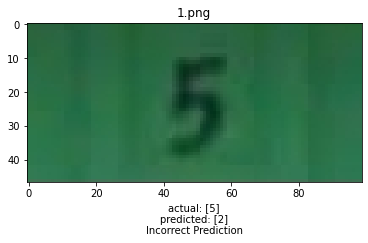

In [152]:
# Example of a Incorrect Prediction
img_index = 1
display_image_with_pred(cnn_model, img_index, local_path)

## Step 5: Results and discussion

### 5a. Confusion Matrix

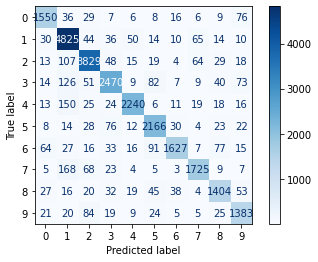

In [153]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### 5b. Accuracy, Precision, Recall, F1 score

$ Precision = \frac{TP}{TP+FP} $  

$ Recall = \frac{TP}{TP+FN} $  

$ F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN} $

In [154]:
# Precision, recall, F1-score
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.8906130983255091, 0.8807476313191989, 0.8849899288715173, None)